# 时间序列分析第四次作业

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入和平稳性检验
采用图检验，发现数据均值不为常数，显然不平稳

均值：283.39285714285717，方差：85.90518707482993


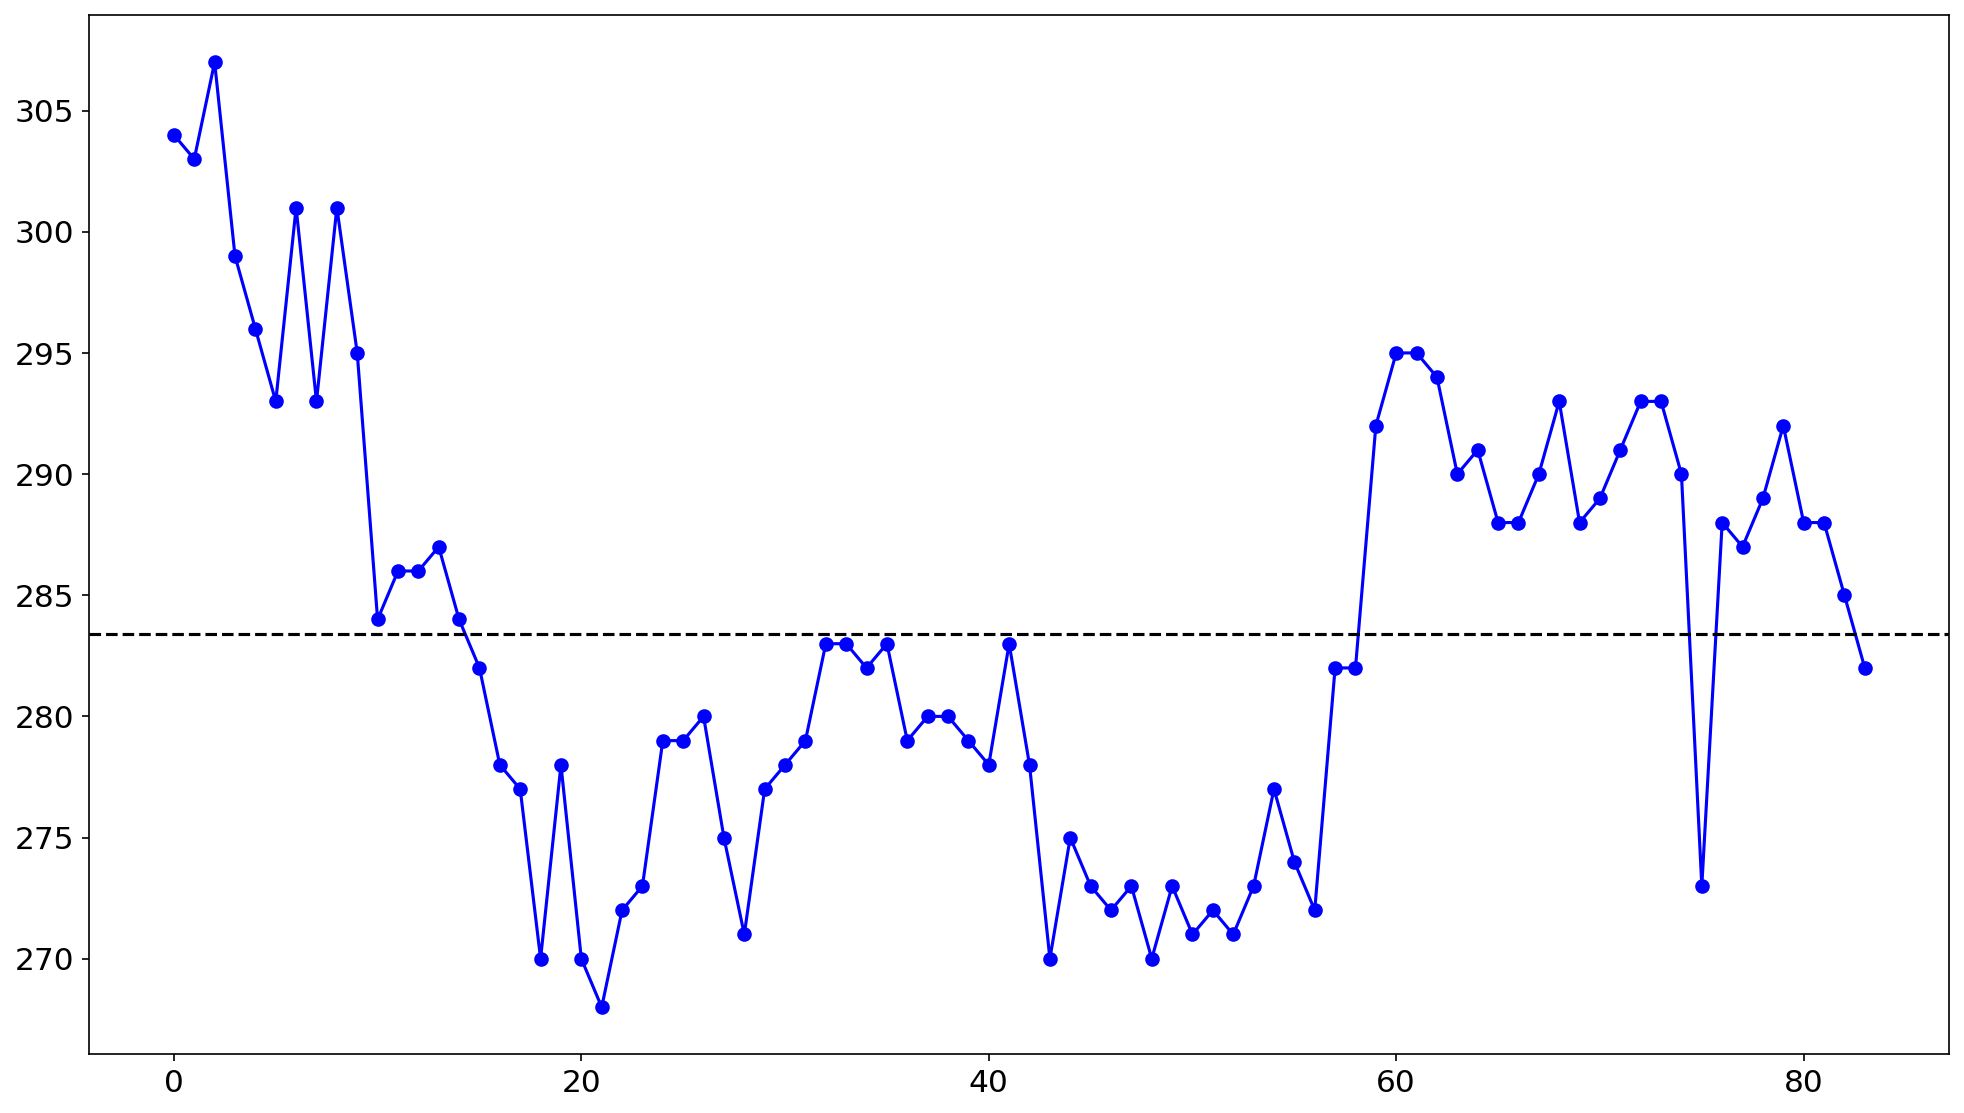

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA

data = [304, 303, 307, 299, 296, 293, 301, 293, 301, 295, 284, 286, 286, 287, 284, 282, 278, 277, 270, 278, 270, 268, 272, 273, 279, 279, 280, 275, 271, 277, 278, 279, 283, 283, 282, 283, 279, 280, 280, 279, 278, 283, 278, 270, 275, 273, 272, 273, 270, 273, 271, 272, 271, 273, 277, 274, 272, 282, 282, 292, 295, 295, 294, 290, 291, 288, 288, 290, 293, 288, 289, 291, 293, 293, 290, 273, 288, 287, 289, 292, 288, 288, 285, 282]

# 计算均值和方差
mean = np.mean(data)
variance = np.var(data)
print(f'均值：{mean}，方差：{variance}')

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')

# 绘制均值线
plt.axhline(y=mean, color='k', linestyle='--')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='序列图.png')


## 二、一阶差分
为了解决不平稳的问题，采用一阶差分

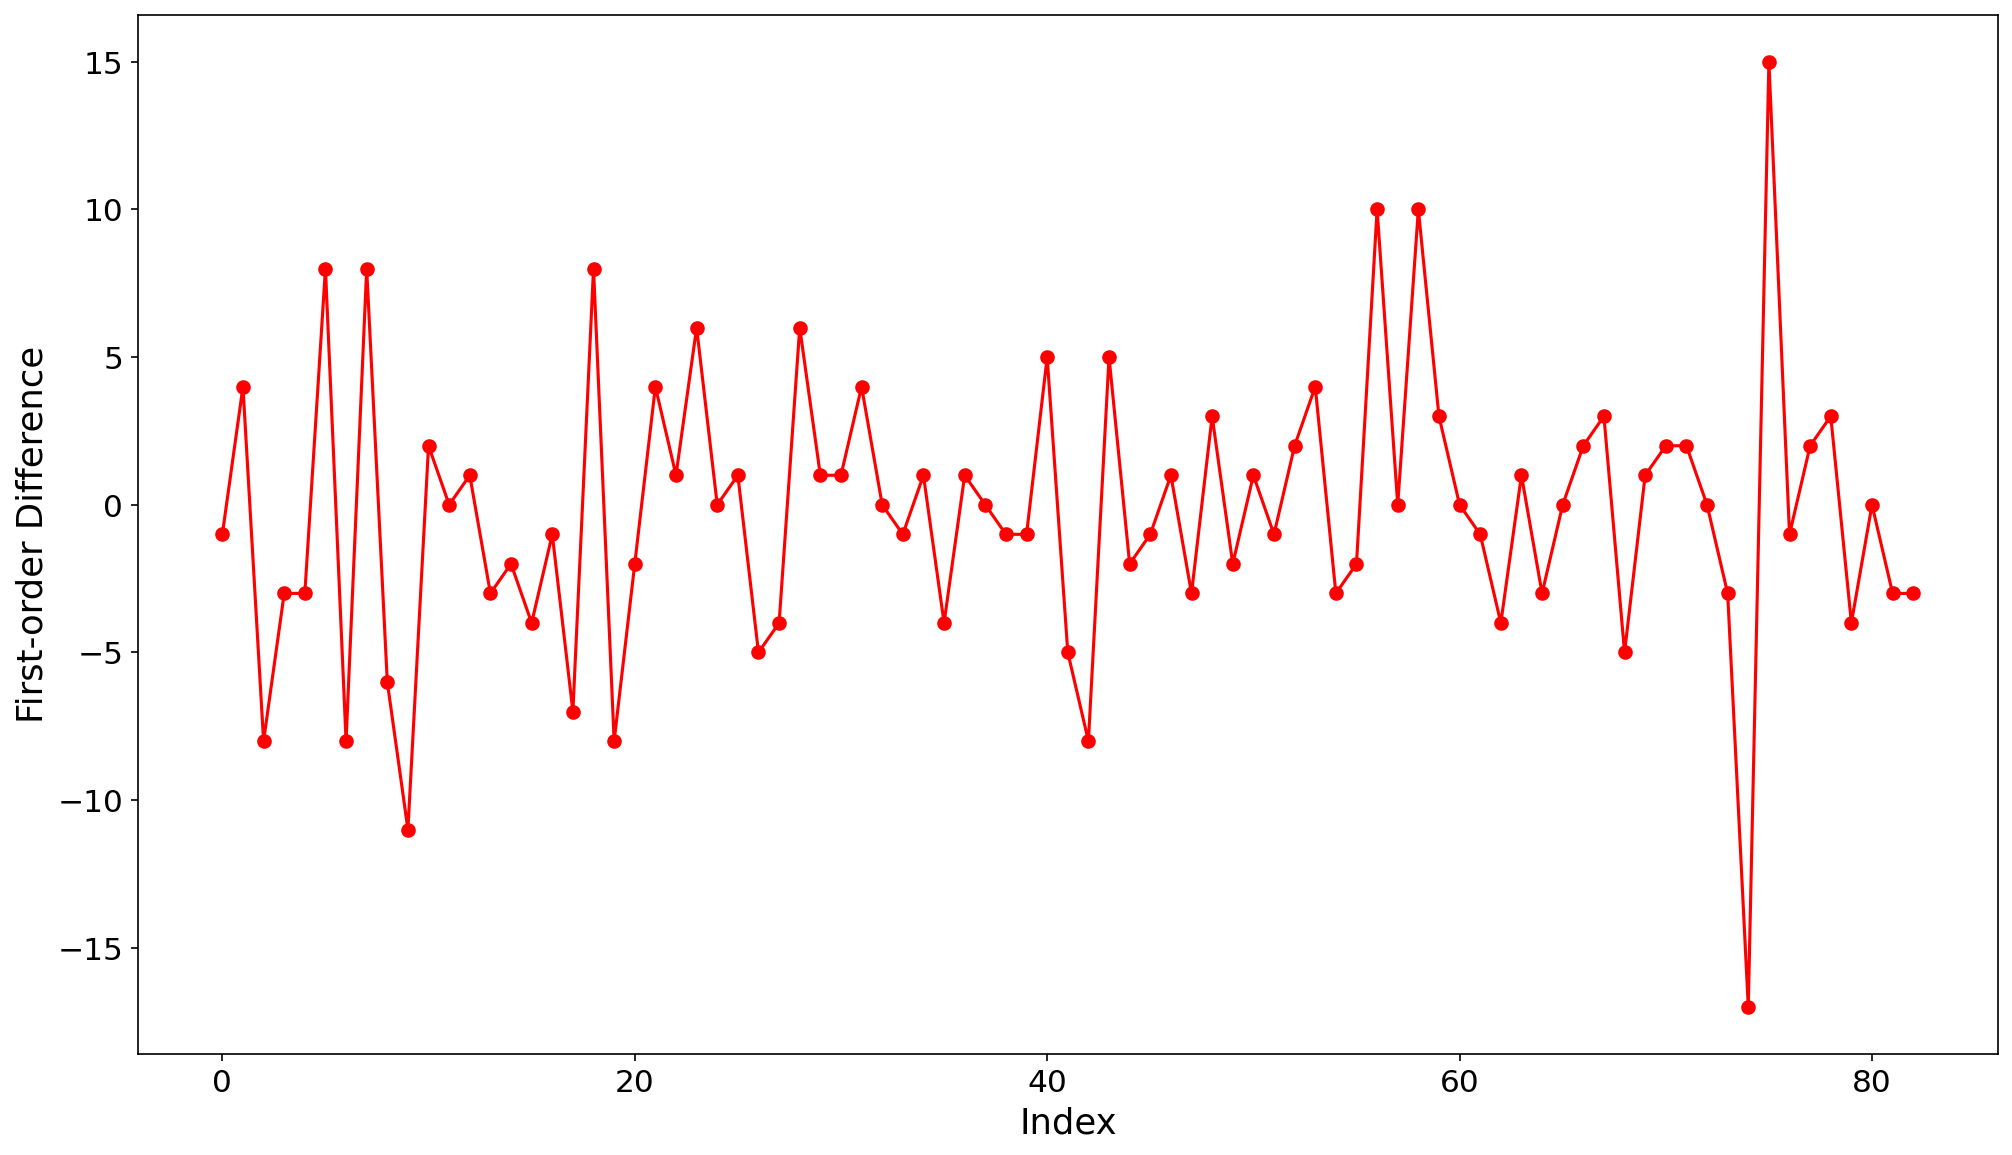

In [3]:
# 进行一阶差分
diff_data = np.diff(data)

# 绘制一阶差分后的序列图
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(diff_data, linestyle='-', color='r', marker='o', markerfacecolor='r')
plt.xlabel('Index', fontsize=17)
plt.ylabel('First-order Difference', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='一阶差分序列图.png')

## 三、平稳性检验
无法通过图检验判断数据的平稳性，因此进一步使用ADF检验判断差分后的数据的平稳性

In [4]:
# 进行 ADF 检验
result = adfuller(diff_data)
print(f'ADF 检验统计量：{result[0]}')
print(f'p 值：{result[1]}')
print('临界值：')
for key, value in result[4].items():
    print(f'{key}: {value}')

if result[1] < 0.05:
    print('一阶差分数据是平稳的。')
else:
    print('一阶差分数据不是平稳的。')

ADF 检验统计量：-11.925085385240669
p 值：4.928564286489847e-22
临界值：
1%: -3.512738056978279
5%: -2.8974898650628984
10%: -2.585948732897085
一阶差分数据是平稳的。


## 四、纯随机检验
已经判断序列为平稳性数据，进一步判断是否为白噪声数据。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，当阶数小于2时，p值小于0.05，即当阶数小于0.05拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [5]:
# 纯随机检验
LB = acorr_ljungbox(diff_data, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    6.777888   0.009229   6.538669   0.010555
2    6.890746   0.031893   6.646215   0.036041
3    6.917591   0.074571   6.671481   0.083140
4    8.783357   0.066749   8.405546   0.077803
5    9.072814   0.106195   8.671165   0.122921
6    9.724198   0.136757   9.261243   0.159410
7    9.754752   0.202903   9.288562   0.232597
8    9.856660   0.275231   9.378480   0.311380
9    9.946868   0.354804   9.457015   0.396200
10  10.011387   0.439495   9.512425   0.484258
11  10.282356   0.505182   9.741952   0.553737
12  10.994581   0.529383  10.336869   0.586433
13  12.036962   0.524615  11.195301   0.594461
14  14.358686   0.423345  13.079994   0.520235
15  14.475188   0.489837  13.173196   0.588922
16  15.393370   0.496038  13.896939   0.606392
17  15.846845   0.534717  14.249049   0.649401
18  15.858463   0.602425  14.257933   0.712129
19  16.038338   0.654719  14.393369   0.760296
20  16.110701   0.709733  14.447002   0.807128


## 五、模型识别
通过观察自相关函数和偏自相关函数，认为自相关函数为1阶截尾，偏自相关函数为拖尾，因此模型为MA(1)模型。

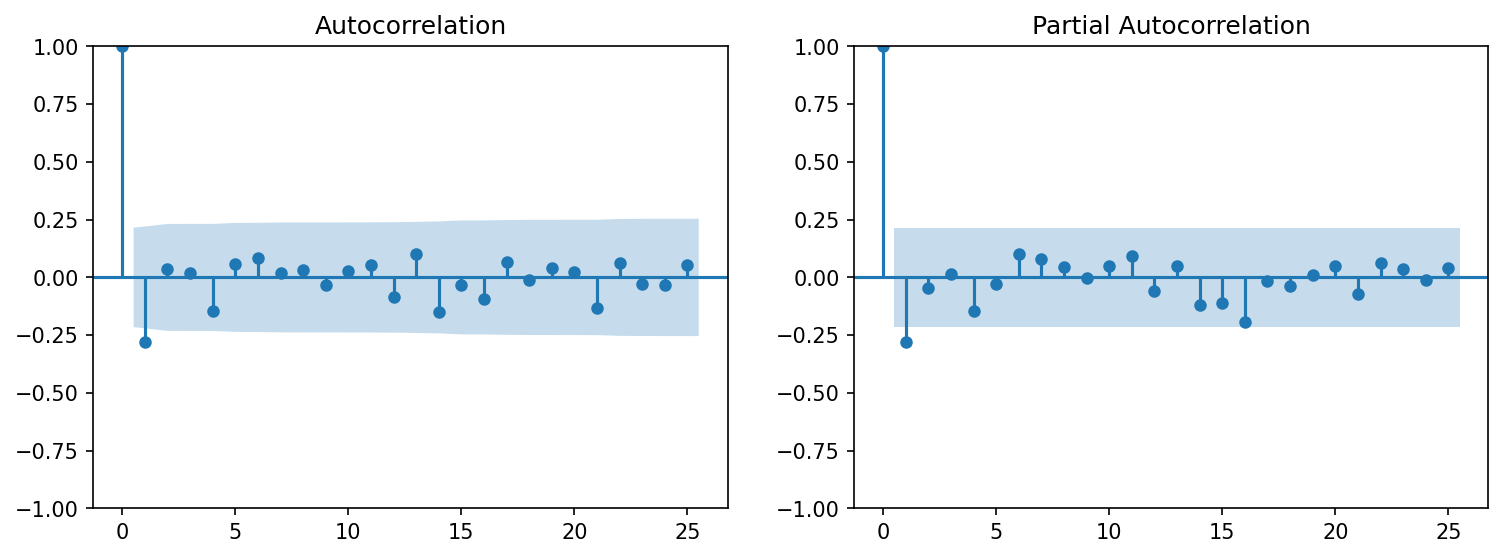

In [6]:
# 绘制自相关图和偏自相关图并识别模型
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(diff_data, lags=25, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(diff_data, lags=25, ax=ax2)
plt.savefig(fname='相关图.png')

## 六、参数估计
使用矩估计估计初值，再使用使用最小化函数进行极大似然估计

In [7]:
# 参数估计
# 定义 MA(1)模型的对数似然函数
def ma1_loglikelihood(params, diff_data):
    mu, theta1, sigma2 = params
    n = len(diff_data)
    loglik = 0
    eps = 0
    for t in range(n):
        xt = diff_data[t]
        et = xt - mu - theta1 * eps
        loglik -= 0.5 * (np.log(2 * np.pi * sigma2) + et**2 / sigma2)
        eps = et
    return loglik

# 矩估计得到的初始值
theta0 = [0, 0.1, np.var(diff_data)]

# 使用最小化函数进行极大似然估计
result = minimize(lambda params: -ma1_loglikelihood(params, diff_data), theta0, method='BFGS')

# 输出参数估计结果
mu_hat, theta1_hat, sigma2_hat = result.x
print(f'均值估计值：{mu_hat}')
print(f'theta1估计值:{theta1_hat}')
print(f'方差估计值：{sigma2_hat}')

均值估计值：-0.2517280610822462
theta1估计值:-0.2925660179409622
方差估计值：20.86477796091047


## 七、模型的检验
### 7.1 模型整体效果的检验
通过通过验证模型对信息的提取是否充分，即残差是否为白噪声序列，来判断模型的整体效果。  
原假设H0：这组数据为纯随机的，序列值之间相互独立。
$$
H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1
$$  
备择假设H1：这组数据非白噪声序列，至少存在一个自相关系数不为零。
$$
H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m
$$  
采用LB统计量作为检验统计量：
$$
LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)
$$
从结果上来看，不论阶数是多少，p值始终大于0.05，可以得出结论：接受原假设，可以认为残差序列为显著的白噪声序列，模型的整体效果检验通过。

In [8]:
# 模型检验
# 模型整体效果检验
epsilon_prev = 0
predictions = []
residuals = []

for xt in diff_data:
    # 计算误差项
    epsilon_t = xt - mu_hat - theta1_hat * epsilon_prev
    # 计算预测值
    xt_pred = mu_hat + theta1_hat * epsilon_prev
    predictions.append(xt_pred)
    residuals.append(xt - xt_pred)
    # 更新误差项
    epsilon_prev = epsilon_t

print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

残差序列： [-0.7482719389177538, 4.032809119576116, -6.568409033687372, -4.669965214111112, -4.114545065533054, 7.047951995620605, -5.686280688919975, 6.588115563030337, -3.8208132029070874, -11.866112042988535, -1.2198930877762044, -0.10517120192214258, 1.22095854133382, -2.391060960408712, -2.447815122758623, -4.4644194620389115, -2.054409363344611, -7.349322305572114, 6.1015660995763215, -5.963161041961141, -3.492890219305004, 3.229827078515247, 2.1966657080813436, 6.894397800043069, 2.268794571541777, 1.9155002544042956, -4.187861657121789, -4.973497947629515, 4.796651571306731, 2.6550653107497157, 2.028509946421474, 4.8452011384604114, 1.6692692642846256, -0.2599004773947613, 1.175690013349906, -3.4043049933790153, 0.2557441053128141, 0.32655009558549036, -0.6527344777940662, -0.9392398658587372, 4.976938393636552, -3.292188891554019, -8.711454533229183, 2.7030524978216404, -0.9574506333447053, -1.0283894580904664, 0.9508562524362544, -2.4700837115082126, 2.5290655056254563, -1.0083533

### 7.2 参数检验
通过验证模型的参数是否是显著影响因素，即使用t检验来检验模型参数是否为0，该参数的显著性。  
原假设H0：参数为0，其不是模型的显著影响因素。
$$
H_0: \mu = 0, \theta_1 = 0
$$  
备择假设H1：参数不为0，其是模型的显著影响因素。
$$
H_0: \mu \neq 0, \theta_1 \neq 0
$$  
检验统计量：
$$
t_{\mu}=\hat{\mu}/{\sqrt{\sigma^2/n}}
$$
$$
t_1=\hat{\theta_1}/{Se}
$$
从结果上来看，mu并不是显著参数，因此需要调整模型。

In [9]:
# 模型的参数检验
# 计算标准误差
n = len(diff_data)
se_mu = np.sqrt(sigma2_hat / n)
residuals_array = np.array(residuals)
se_theta1 = np.sqrt(sigma2_hat / np.sum(residuals_array**2))

# 计算 t 值
t_mu = mu_hat / se_mu
t_theta1 = theta1_hat / se_theta1

# 假设显著性水平为 0.05，自由度为 n - 2
critical_value = stats.t.ppf(1 - 0.05 / 2, n - 2)

print(f"mu 的 t 值为：{t_mu}，临界值为：{critical_value}")
print(f"theta1 的 t 值为：{t_theta1}，临界值为：{critical_value}")

mu 的 t 值为：-0.5020694465702922，临界值为：1.9896863232444828
theta1 的 t 值为：-2.6654039874391855，临界值为：1.9896863232444828


### 7.3 模型的调整
由上述计算，MA(1)的参数mu并不显著，因此需要调整模型，重新检验。  
结果表明检验通过

In [12]:
# MA(1)，去掉均值参数后的参数估计
def ma1_loglikelihood_no_mu(params, diff_data):
    theta1, sigma2 = params
    n = len(diff_data)
    loglik = 0
    eps = 0
    for t in range(n):
        xt = diff_data[t]
        et = xt - theta1 * eps
        loglik -= 0.5 * (np.log(2 * np.pi * sigma2) + et**2 / sigma2)
        eps = et
    return loglik

# 初始值
theta0_no_mu = [0.1, np.var(diff_data)]

# 极大似然估计
result_no_mu = minimize(lambda params: -ma1_loglikelihood_no_mu(params, diff_data), theta0_no_mu, method='BFGS')

# 输出参数估计结果
theta1_hat_no_mu, sigma2_hat_no_mu = result_no_mu.x
print(f'theta1估计值（无均值参数）:{theta1_hat_no_mu}')
print(f'方差估计值（无均值参数）：{sigma2_hat_no_mu}')

# 模型检验
# 模型整体效果检验
epsilon_prev_no_mu = 0
predictions_no_mu = []
residuals_no_mu = []

for xt in diff_data:
    # 计算误差项
    epsilon_t = xt - theta1_hat_no_mu * epsilon_prev_no_mu
    # 计算预测值
    xt_pred = theta1_hat_no_mu * epsilon_prev_no_mu
    predictions_no_mu.append(xt_pred)
    residuals_no_mu.append(xt - xt_pred)
    # 更新误差项
    epsilon_prev_no_mu = epsilon_t

print("残差序列（无均值参数）：", residuals_no_mu)

# 检验残差序列为白噪声
LB_no_mu = acorr_ljungbox(residuals_no_mu, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB_no_mu)

# 模型的参数检验
# 计算标准误差
n = len(diff_data)
residuals_array_no_mu = np.array(residuals_no_mu)
se_theta1_no_mu = np.sqrt(sigma2_hat_no_mu / np.sum(residuals_array_no_mu**2))

# 计算 t 值
t_theta1_no_mu = theta1_hat_no_mu / se_theta1_no_mu

# 假设显著性水平为 0.05，自由度为 n - 1
critical_value_no_mu = stats.t.ppf(1 - 0.05 / 2, n - 1)

print(f"theta1 的 t 值（无均值参数）为：{t_theta1_no_mu}，临界值为：{critical_value_no_mu}")

theta1估计值（无均值参数）:-0.28622754855531174
方差估计值（无均值参数）：20.989395409499128
残差序列（无均值参数）： [-1.0, 3.7137724514446884, -6.9370160153307365, -4.9855650883570535, -4.427006073403385, 6.732868904170273, -6.072867438815055, 6.261778040286592, -4.207706621931285, -12.204361551435344, -1.4932244885500396, -0.427401984800437, 0.8776657776428963, -2.7487878760143825, -2.786778815250159, -4.797652868654929, -2.3732204194144595, -7.67928106283041, 5.8019782067188235, -6.3393140011195275, -3.814486306062807, 2.908188935617836, 1.8324037897775747, 6.524484444711498, 1.8674871881970365, 1.53452627983609, -4.5607763047288135, -5.305419821211681, 4.48144269051782, 2.2827123552980364, 1.6533751615138788, 4.47324151932236, 1.2803649541714772, -0.633524277911364, 0.8186678989831563, -3.7656746941931236, -0.07783983637567093, -0.022279905545754874, -1.0063771227464053, -1.2880528567658516, 4.6313237883982445, -3.6743875454808714, -9.05171093958516, 2.409150967531242, -1.3104346244638752, -1.3750824901022956, 0.60

## 八、模型的优化
事实上，通过观察相关图，不只有MA(1)一种模型猜想，进一步猜想模型可能还有是自相关函数拖尾、偏自相关函数1阶截尾，为AR(1)模型；也有可能是自相关函数拖尾、偏自相关函数拖尾的可能，为ARMA(1,1)模型。  
因此为了跟进一步检验为何种模型，并防止过拟合的情况出现，使用最佳准则函数AIC来判断最优模型。  
AIC结果表明，选择MA(1)模型。

In [11]:
## 模型的优化
# 尝试MA(1)模型
ma1_model = ARIMA(diff_data, order=(0, 0, 1))
ma1_results = ma1_model.fit()
ma1_aic = ma1_results.aic

# 尝试AR(1)模型
ar1_model = ARIMA(diff_data, order=(1, 0, 0))
ar1_results = ar1_model.fit()
ar1_aic = ar1_results.aic

# 尝试ARMA(1,1)模型
arma11_model = ARIMA(diff_data, order=(1, 0, 1))
arma11_results = arma11_model.fit()
arma11_aic = arma11_results.aic

# 最佳准则函数选择模型
print(f'MA(1)模型的 AIC 值：{ma1_aic}')
print(f'AR(1)模型的 AIC 值：{ar1_aic}')
print(f'ARMA(1,1)模型的 AIC 值：{arma11_aic}')

MA(1)模型的 AIC 值：493.7911305359625
AR(1)模型的 AIC 值：493.9433780444108
ARMA(1,1)模型的 AIC 值：495.74637110581523


## 九、模型的预测
首先点预测，在绘制出95%置信区间下的预测区间

未来五个一阶差分预测数据：[ 0.7841257  -0.25175479 -0.25175479 -0.25175479 -0.25175479]
95%置信区间下限：[-8.22302674 -9.25890724 -9.25890724 -9.25890724 -9.25890724]
95%置信区间上限：[9.79127815 8.75539766 8.75539766 8.75539766 8.75539766]
未来五个原始预测数据：[282.78412570313714, 282.5323709127455, 282.2806161223538, 282.02886133196216, 281.7771065415705]
未来五个原始预测数据95%置信区间上限：[292.5754038522223, 301.33080150777863, 310.086199163335, 318.84159681889133, 327.5969944744477]
未来五个原始预测数据95%置信区间下限：[274.56109896032626, 265.3021917239866, 256.04328448764693, 246.78437725130723, 237.52547001496754]


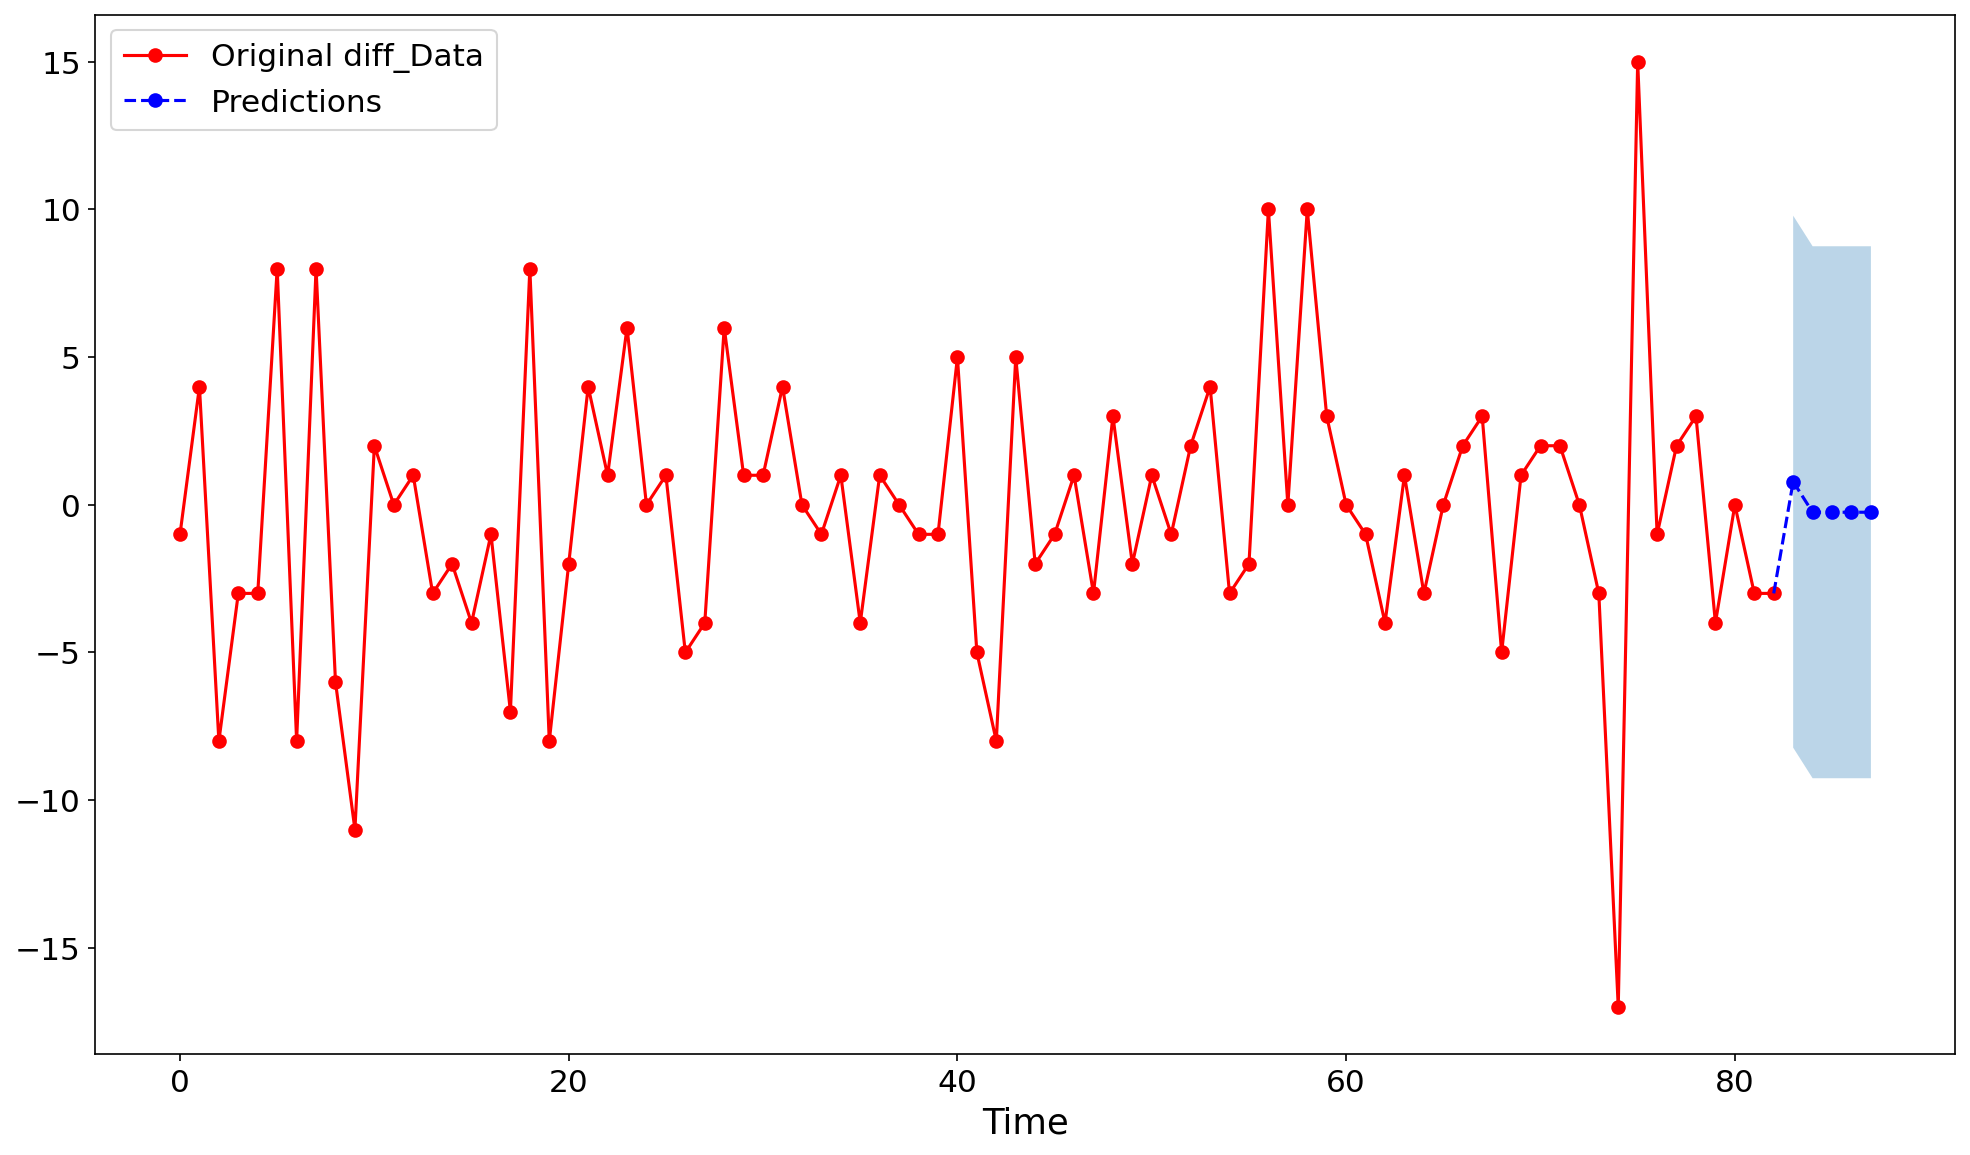

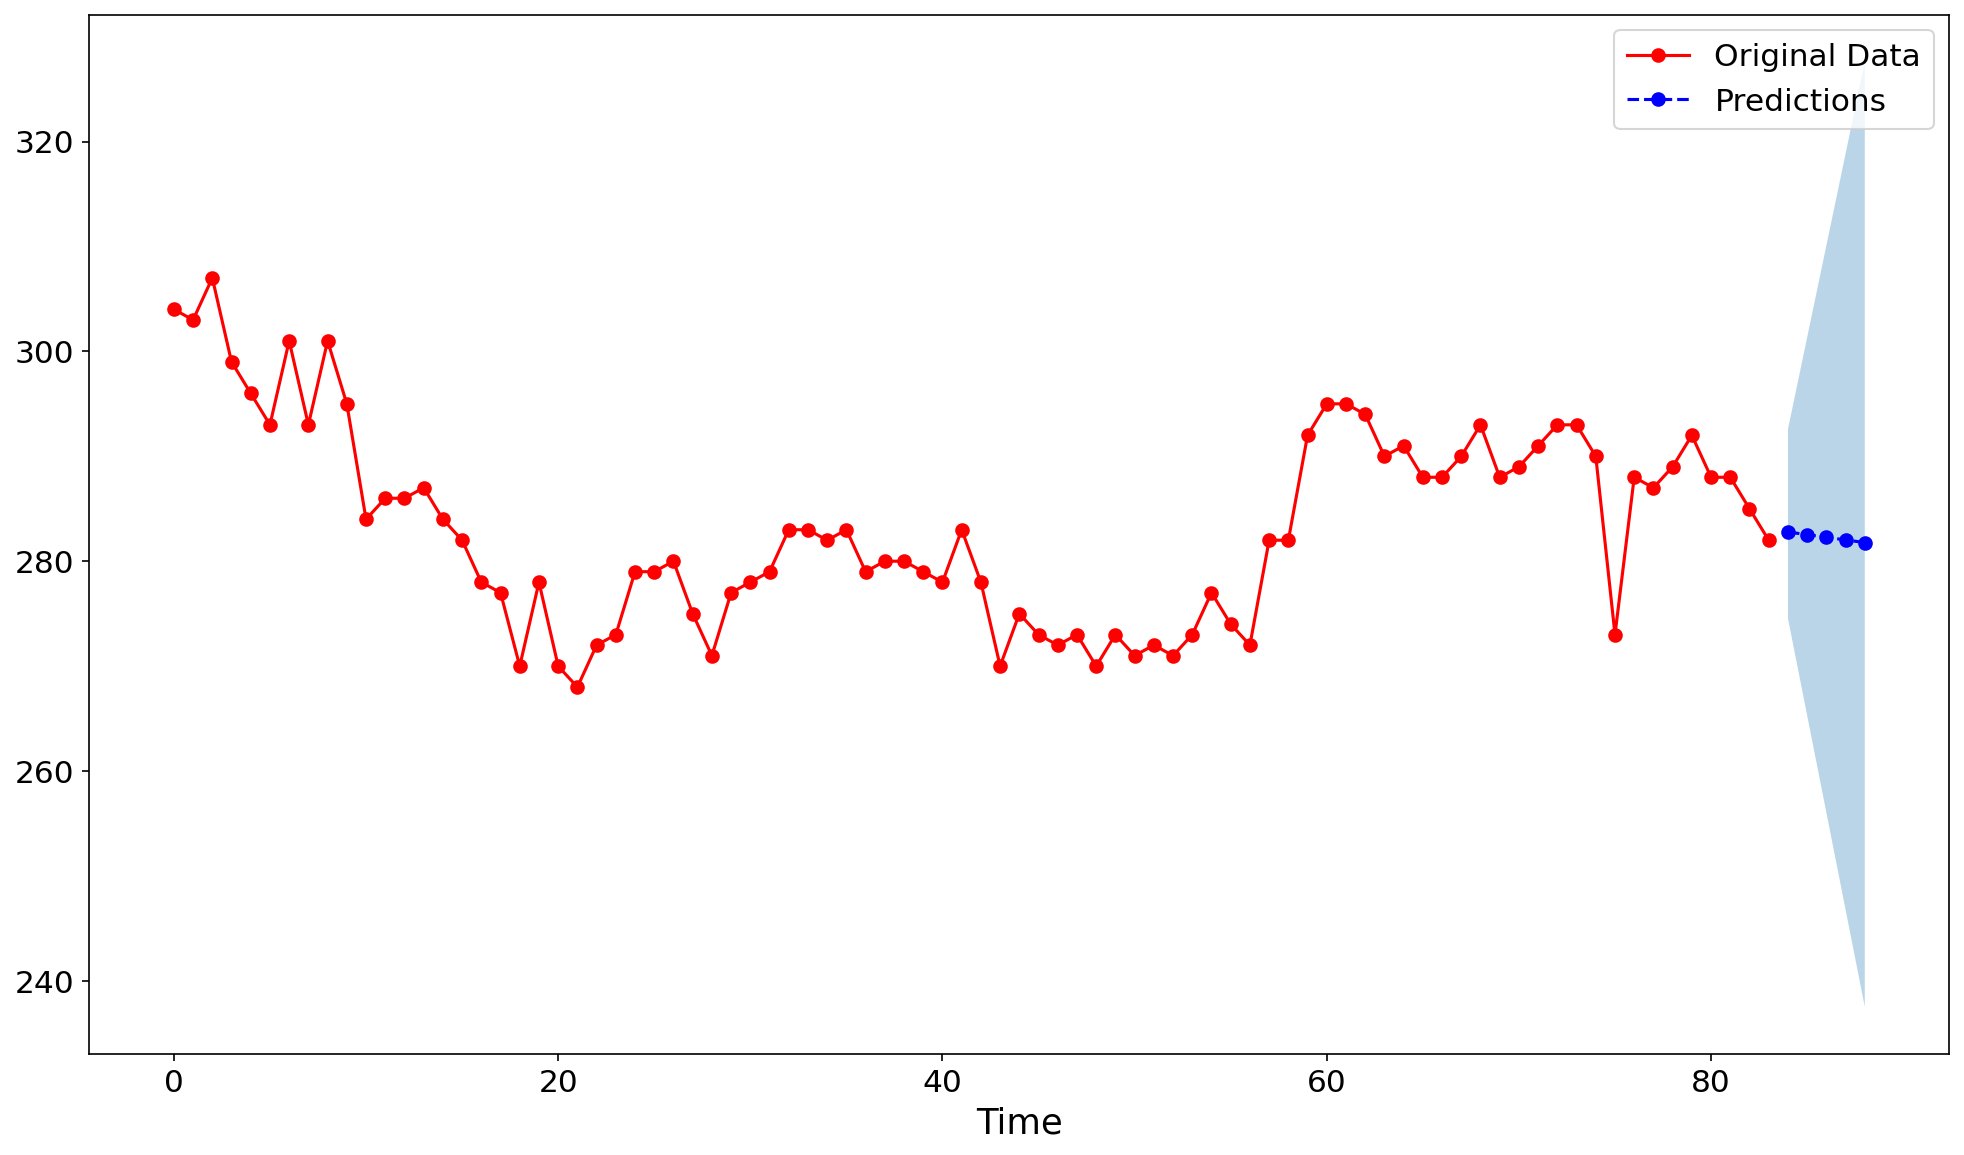

In [13]:
## 模型的预测
# 预测未来 5 个时间点
num_steps = 5
predictions = ma1_results.forecast(steps=num_steps)
print(f'未来五个一阶差分预测数据：{predictions}')

# 一阶差分数据预测
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(diff_data, linestyle='-', color='r', marker='o', markerfacecolor='r', label='Original diff_Data')
plt.plot(range(len(diff_data), len(diff_data) + num_steps), predictions, linestyle='--', color='b', marker='o', markerfacecolor='b', label='Predictions')
plt.plot([len(diff_data)-1, len(diff_data)], [diff_data[-1], predictions[0]], color='b', linestyle='--')

# 计算 95%置信区间
residuals = ma1_results.resid
residual_std = np.std(residuals)
standard_error = residual_std * np.sqrt(1 + 1/len(diff_data))
confidence_interval = 1.96 * standard_error
lower_bounds = predictions - confidence_interval
upper_bounds = predictions + confidence_interval

print(f'95%置信区间下限：{lower_bounds}')
print(f'95%置信区间上限：{upper_bounds}')

# 可视化置信区间
plt.fill_between(range(len(diff_data), len(diff_data) + num_steps), lower_bounds, upper_bounds, alpha=0.3)

plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='一阶差分数据预测结果.png')

# 将一阶差分预测结果还原成原始数据预测
predictions_diff = ma1_results.forecast(steps=num_steps)
predictions_original = [data[-1]]
for diff_pred in predictions_diff:
    next_pred = predictions_original[-1] + diff_pred
    predictions_original.append(next_pred)
predictions_original = predictions_original[-5:]
print(f'未来五个原始预测数据：{predictions_original}')

# 还原区间上下限
lower_bounds_original = [predictions_original[0]]
upper_bounds_original = [predictions_original[0]]
for diff_pred in predictions_diff:
    lower_bound_next = lower_bounds_original[-1] + diff_pred - confidence_interval
    upper_bound_next = upper_bounds_original[-1] + diff_pred + confidence_interval
    lower_bounds_original.append(lower_bound_next)
    upper_bounds_original.append(upper_bound_next)
# 取后五个
lower_bounds_original = lower_bounds_original[-5:]
upper_bounds_original = upper_bounds_original[-5:]
print(f'未来五个原始预测数据95%置信区间上限：{upper_bounds_original}')
print(f'未来五个原始预测数据95%置信区间下限：{lower_bounds_original}')


# 绘制原始预测数据及区间上下限与原始序列一起
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(data)), data, linestyle='-', color='r', marker='o', markerfacecolor='r', label='Original Data')
plt.plot(range(len(data), len(data) + 5), predictions_original, linestyle='--', color='b', marker='o', markerfacecolor='b', label='Predictions')
plt.fill_between(range(len(data), len(data) + 5), lower_bounds_original, upper_bounds_original, alpha=0.3)
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='原始数据预测结果.png')